# Proposed Ensemble Models

Given the constraints and objectives, I recommend considering the following models for the ensemble:
	
    1.	Model 1: LSTM Network on Raw GPS Data
    
>•	Input Data: Sequences of raw GPS data (speed, progress, stride_frequency, etc.).

>•	Architecture: An LSTM network designed to capture temporal dependencies and patterns in the sequential data.

>•	Advantage: LSTMs are well-suited for time-series data and can learn complex temporal dynamics without the need for hand-engineered features like acceleration.

    2.	Model 2: 1D Convolutional Neural Network (1D-CNN)
	
>•	Input Data: The same raw GPS sequences as in Model 1.

>•	Architecture: A 1D-CNN that applies convolutional filters across the time dimension to detect local patterns.

>•	Advantage: CNNs can capture spatial hierarchies and are effective in recognizing patterns in sequences, potentially identifying features like sudden changes in speed or stride frequency.

    3.	Model 3: Transformer-based Model
	
>•	Input Data: Raw GPS sequences and possibly sectionals data.

>•	Architecture: A Transformer model that uses self-attention mechanisms to weigh the importance of different parts of the sequence.

>•	Advantage: Transformers can model long-range dependencies and focus on the most relevant parts of the sequence for prediction.

## Additional Models (Optional):

    4.	Model 4: Gated Recurrent Unit (GRU) Network

>•	Similar to LSTMs but with a simpler architecture, GRUs can be more efficient and may perform better on certain datasets.

>•	Model 5: Temporal Convolutional Network (TCN)

>•	TCNs are designed for sequential data and can capture long-term dependencies using causal convolutions and residual connections.


### Validate GPU Setup

In [59]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [60]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))

Num GPUs Available: 2


In [61]:
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# The LSTM Network on Raw GPS Data

Initially I desired to merge the GPS data with Sectionals, but the timestamp and gate_name intervals of each respectively made it difficult to align the data in sequences -- something that is needed for Long-Short Term Memory models. Therefore, it was decided to go with an ensemble approach. There will be additional models that incorporate Equibase data as well, but for the time being, the focus will be on Total Performance GPS data. 

In [12]:
# Environment setup

import logging
import os
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
import geopandas as gpd
from datetime import datetime
import configparser
from src.data_ingestion.ingestion_utils import (
    get_db_connection, update_tracking, load_processed_files
)
import traceback

# Load the configuration file
config = configparser.ConfigParser()
config.read('/home/exx/myCode/horse-racing/FoxRiverAIRacing/config.ini')

# Set up logging for consistent logging behavior in Notebook
logging.basicConfig(level=logging.INFO)

# Retrieve database credentials from config file
# Retrieve database credentials from config file
db_host = config['database']['host']
db_port = config['database']['port']
db_name = config['database']['dbname']  # Corrected from 'name' to 'dbname'
db_user = config['database']['user']

# Establish connection using get_db_connection
conn = get_db_connection(config)

# Create the SQLAlchemy engine
engine = create_engine(f'postgresql+psycopg2://{db_user}@{db_host}:{db_port}/{db_name}')

In [62]:
query_results = """
   SELECT course_cd, race_date, race_number, program_num, post_pos, axciskey, official_fin
    FROM v_results_entries
    WHERE breed = 'TB';
"""

query_sectionals = """    
    
SELECT course_cd, race_date, race_number, saddle_cloth_number, gate_name, gate_numeric, 
    length_to_finish,sectional_time, running_time, distance_back, distance_ran, 
    number_of_strides, post_time 
FROM v_sectionals;
"""

query_gpspoint = """
select course_cd, race_date, race_number, saddle_cloth_number, time_stamp, 
longitude, latitude, speed, progress, stride_frequency, post_time, location
from v_gpspoint;
"""


query_routes = """
select course_cd, track_name, line_type, line_name, coordinates
from routes;
"""



In [137]:
# Execute the query and load data into a DataFrame
gps_df = pd.read_sql_query(query_gpspoint, engine, parse_dates=['time_stamp'])


In [140]:
gps_df.dtypes
print(gps_df.shape)

(36590003, 12)


In [138]:
sectionals_df = pd.read_sql_query(query_sectionals, engine)


In [143]:
sectionals_df.dtypes
print(sectionals_df.shape)

(4737778, 13)


In [63]:
results_df = pd.read_sql_query(query_results, engine)


In [64]:
results_df.dtypes

course_cd       object
race_date       object
race_number      int64
program_num     object
post_pos         int64
axciskey        object
official_fin     int64
dtype: object

In [65]:
print(results_df.shape)

(387680, 7)


In [148]:
routes_df = pd.read_sql_query(query_routes, engine)

In [149]:
routes_df.dtypes

course_cd      object
track_name     object
line_type      object
line_name      object
coordinates    object
dtype: object

In [150]:
routes_df.shape

(125, 5)

In [68]:
gps_df['race_date'] = pd.to_datetime(gps_df['race_date'])
sectionals_df['race_date'] = pd.to_datetime(sectionals_df['race_date'])
results_df['race_date'] = pd.to_datetime(results_df['race_date'])

In [ ]:
gps_df.to_parquet('/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/training/gps.parquet', index=False)


In [ ]:
sectionals_df.to_parquet('/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/training/sectionals.parquet', index=False)

In [69]:
results_df.to_parquet('/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/training/results.parquet', index=False)

In [154]:
routes_df.to_parquet('/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/training/routes.parquet', index=False)

# Start here if data is current in parquet

In [14]:
# Load the Parquet file into a DataFrame
gps_df = pd.read_parquet('/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/training/gps.parquet')
print(gps_df.shape)

(36590003, 12)


In [21]:
# Filter for races on '2024-01-01'
gps_df = gps_df[gps_df['race_date'] >= '2024-01-01']
print(gps_df.shape)

(13079926, 12)


In [15]:
# Load the Parquet file into a DataFrame
sectionals_df = pd.read_parquet('/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/training/sectionals.parquet')
print(sectionals_df.shape)

(4737778, 13)


In [20]:
# Filter for races on '2024-01-01'
sectionals_df = sectionals_df[sectionals_df['race_date'] >= '2024-01-01']
print(sectionals_df.shape)

(1682918, 13)


In [70]:
# Load the Parquet file into a DataFrame
results_df = pd.read_parquet('/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/training/results.parquet')
print(results_df.shape)

(387680, 7)


In [71]:
# Filter for races on '2024-01-01'
results_df = results_df[results_df['race_date'] >= '2024-01-01']
print(results_df.shape)

(115181, 7)


In [17]:
# Load the Parquet file into a DataFrame
routes_df = pd.read_parquet('/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/training/routes.parquet')
print(routes_df.shape)

(125, 5)


## Mapping GPS to Sectionals

### Objective

>	•	Goal: Merge the gpspoint data with the sectionals data to incorporate gate-specific features into the sequences used for the LSTM model.

>    •	Challenge: Since the sectionals data does not have time_stamp, we need an alternative method to align the data.

### Proposed Solution: Use running_time to Estimate time_stamp in sectionals Data

Why Use post_time?

>	•	running_time in the sectionals data represents the total time from the official start of the race to when the horse passed each gate.

>    •	We can use running_time to estimate the time_stamp of gate events by adding it to the race start time.


### Implementation Steps

1. Ensure gpspoint Data is Properly Formatted

>	•	Convert time_stamp to datetime:

### Action: Convert Data Types and Standardize Column Names

In [72]:
import pandas as pd

# Convert 'race_date' to datetime in all DataFrames
gps_df['race_date'] = pd.to_datetime(gps_df['race_date'])
sectionals_df['race_date'] = pd.to_datetime(sectionals_df['race_date'])
results_df['race_date'] = pd.to_datetime(results_df['race_date'])

# Ensure 'race_number' is int in all DataFrames
gps_df['race_number'] = gps_df['race_number'].astype(int)
sectionals_df['race_number'] = sectionals_df['race_number'].astype(int)
results_df['race_number'] = results_df['race_number'].astype(int)

# Standardize 'saddle_cloth_number' and 'program_num' to strings and strip whitespace
gps_df['saddle_cloth_number'] = gps_df['saddle_cloth_number'].astype(str).str.strip()
sectionals_df['saddle_cloth_number'] = sectionals_df['saddle_cloth_number'].astype(str).str.strip()
results_df['program_num'] = results_df['program_num'].astype(str).str.strip()

# Rename 'program_num' to 'saddle_cloth_number' in results_df for consistency
results_df.rename(columns={'program_num': 'saddle_cloth_number'}, inplace=True)

# Confirm data types
print("gps_df.dtypes:")
print(gps_df.dtypes)
print("\nsectionals_df.dtypes:")
print(sectionals_df.dtypes)
print("\nresults_df.dtypes:")
print(results_df.dtypes)

gps_df.dtypes:
course_cd                      object
race_date              datetime64[ns]
race_number                     int64
saddle_cloth_number            object
time_stamp             datetime64[ns]
longitude                     float64
latitude                      float64
speed                         float64
progress                      float64
stride_frequency              float64
post_time              datetime64[ns]
location                       object
dtype: object

sectionals_df.dtypes:
course_cd                      object
race_date              datetime64[ns]
race_number                     int64
saddle_cloth_number            object
gate_name                      object
gate_numeric                  float64
length_to_finish              float64
sectional_time                float64
running_time                  float64
distance_back                 float64
distance_ran                  float64
number_of_strides             float64
post_time              datetime64[ns

### Overview of solution

#### The problem:

No, I do not believe it is causing a cartesian join.  I explained this earlier, the two do not have the same primary keys. The gps data has course_cd, race_date, race_number, saddle_cloth_number, and timestamp.  Each horse has at least 120 timestamps per race. Then the sectionals data has the course_cd, race_date, race_number, saddle_cloth_number, and gate_name (which we converted to gate_numeric so it would sort correctly). If you join on the partial key, you will get back more rows of data -- each unique horse will merge 120 times, to each unique horse in sectionals for at least 20 times. So the problem is that the time has to be taken into account -- use the timestamp, and compute the equivalent timestamp for each sectional gate_numeric. For example, when a horse takes off at post_time, the first gate (typically at 0.5f) will be reached in the sectional_time, and this time should match with one of the timestamps (or at least within a second or two). The next gate, (1f), would be the sectional_time added on, etc. This is why I thought that the gate_numeric was being ignored and it can't be for a time series analysis. There are several ways that I see it being possible -- like using distance (length_to_finish), etc. but I'm not smart enough to put that in code. Can you do it?  Do you agree with my logic, or am I missing something?


### Overview of the Solution

>	1.	Calculate Cumulative Sectional Times: For each horse in each race, compute the cumulative times at which they reach each gate.

>   2.	Assign Sectional Timestamps: Add these cumulative times to the post_time to get the estimated timestamp when each horse passes each gate.
	
>   3.	Match GPS Points to Sectionals: For each GPS point, find the sectional whose timestamp range it falls into.

>.  4.	Handle Possible Time Variances: Allow for slight discrepancies due to timing differences.

### First, compute the cumulative times for each sectional gate for each horse.

In [73]:
sectionals_df.dtypes

course_cd                      object
race_date              datetime64[ns]
race_number                     int64
saddle_cloth_number            object
gate_name                      object
gate_numeric                  float64
length_to_finish              float64
sectional_time                float64
running_time                  float64
distance_back                 float64
distance_ran                  float64
number_of_strides             float64
post_time              datetime64[ns]
cumulative_time               float64
sectional_timestamp    datetime64[ns]
dtype: object

In [74]:
# Set pandas display options for maximum space
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)     # Set max rows to display
pd.set_option('display.width', 1000)      # Increase display width
pd.set_option('display.colheader_justify', 'center')  # Center-align headers


In [75]:
# List of columns to include from sectionals_df
sectionals_columns = [
    'course_cd', 
    'race_date',
    'race_number',
    'saddle_cloth_number',
    'gate_name',
    'gate_numeric',
    'length_to_finish',
    'sectional_time',
    'running_time',
    'distance_back',
    'distance_ran',
    'number_of_strides',
    'post_time'     
]

sectionals_patterns = [
    'course_cd', 
    'race_date',
    'race_number',
    'saddle_cloth_number',
    'gate_name',
    'length_to_finish',
    'sectional_timestamp',
    'sectional_time',
    'cumulative_time',
    'distance_back',
    'distance_ran',
    'number_of_strides']

# Ensure data is sorted correctly
sectionals_df = sectionals_df.sort_values(by=[
    'course_cd', 'race_date', 'race_number', 'saddle_cloth_number', 'gate_numeric'
])



In [76]:
# Calculate cumulative running times
sectionals_df['cumulative_time'] = sectionals_df.groupby([
    'course_cd', 'race_date', 'race_number', 'saddle_cloth_number'
])['sectional_time'].cumsum()

In [77]:
sec = sectionals_df[sectionals_patterns]
sec.head(30)

,course_cd,race_date,race_number,saddle_cloth_number,gate_name,length_to_finish,sectional_timestamp,sectional_time,cumulative_time,distance_back,distance_ran,number_of_strides
120626,AQU,2024-01-01,1,1,0.5f,100.6,2024-01-01 12:50:06.430,6.43,6.43,24.5,100.6,15.1
120623,AQU,2024-01-01,1,1,1f,201.2,2024-01-01 12:50:12.660,6.23,12.66,22.4,100.6,15.0
120619,AQU,2024-01-01,1,1,1.5f,301.8,2024-01-01 12:50:18.950,6.29,18.95,19.8,101.0,14.6
120615,AQU,2024-01-01,1,1,2f,402.3,2024-01-01 12:50:25.210,6.26,25.21,15.9,100.7,14.7
120612,AQU,2024-01-01,1,1,2.5f,502.9,2024-01-01 12:50:31.390,6.18,31.39,12.8,101.2,14.4
120608,AQU,2024-01-01,1,1,3f,603.5,2024-01-01 12:50:37.450,6.06,37.45,10.5,101.3,14.6
120605,AQU,2024-01-01,1,1,3.5f,704.1,2024-01-01 12:50:43.300,5.85,43.30,8.8,101.6,14.2
120601,AQU,2024-01-01,1,1,4f,804.7,2024-01-01 12:50:48.870,5.57,48.87,7.5,100.2,13.4
120544,AQU,2024-01-01,1,1,4.5f,905.3,2024-01-01 12:50:54.420,5.55,54.42,6.8,100.6,13.3
1483,AQU,2024-01-01,1,1,5f,1005.8,2024-01-01 12:51:00.020,5.60,60.02,4.8,100.6,14.0


### Step 2: Calculate Sectional Timestamps

Add the cumulative times to the post_time to get the estimated timestamp when each horse reaches each gate.

In [78]:
# Calculate the estimated timestamp when each horse reaches each gate
sectionals_df['sectional_timestamp'] = sectionals_df['post_time'] + pd.to_timedelta(sectionals_df['cumulative_time'], unit='s')

I converted the cumulative times from seconds to a Timedelta and add it to post_time to get the exact timestamp for each gate.

### Step 3: Prepare GPS Data

Ensure that the time_stamp in gps_df is timezone-aware or naive consistently with post_time.


In [87]:
# Ensure data is sorted correctly
gps_df = gps_df.sort_values(by=[
    'course_cd', 'race_date', 'race_number', 'saddle_cloth_number', 'time_stamp'
])


In [88]:
# Remove timezone info if present for consistency
gps_df['time_stamp'] = gps_df['time_stamp'].dt.tz_localize(None)
gps_df['post_time'] = gps_df['post_time'].dt.tz_localize(None)
sectionals_df['post_time'] = sectionals_df['post_time'].dt.tz_localize(None)
sectionals_df['sectional_timestamp'] = sectionals_df['sectional_timestamp'].dt.tz_localize(None)

In [90]:
gps_df[['time_stamp', 'post_time']].head (40)

,time_stamp,post_time
420211,2024-01-01 17:52:06.200,2024-01-01 12:50:00
420215,2024-01-01 17:52:07.200,2024-01-01 12:50:00
420218,2024-01-01 17:52:08.200,2024-01-01 12:50:00
420221,2024-01-01 17:52:09.200,2024-01-01 12:50:00
420225,2024-01-01 17:52:10.200,2024-01-01 12:50:00
420229,2024-01-01 17:52:11.200,2024-01-01 12:50:00
420232,2024-01-01 17:52:12.200,2024-01-01 12:50:00
420236,2024-01-01 17:52:13.200,2024-01-01 12:50:00
420240,2024-01-01 17:52:14.200,2024-01-01 12:50:00
44345,2024-01-01 17:52:15.200,2024-01-01 12:50:00


### Step 4: Merge GPS and Sectional Data on Time

We will now match each GPS point to the appropriate sectional by finding the closest sectional_timestamp that is less than or equal to the time_stamp of the GPS point.

#### Option A: Using a Time Window

We can define a time window within which to consider the GPS point as part of a sectional.

In [ ]:
# Ensure all timestamps are aligned relative to post_time
gps_df['time_since_post'] = (gps_df['time_stamp'] - gps_df['post_time']).dt.total_seconds()
sectionals_df['sectional_time_since_post'] = (sectionals_df['post_time'] + pd.to_timedelta(sectionals_df['cumulative_time'], unit='s')).dt.total_seconds()

# Updated assignment function
def assign_sectional_to_gps(gps_group, sectionals_group):
    gps_group = gps_group.sort_values('time_since_post').reset_index(drop=True)
    sectionals_group = sectionals_group.sort_values('sectional_time_since_post').reset_index(drop=True)

    gate_names = []
    sec_idx = 0
    num_sectionals = len(sectionals_group)

    for idx, gps_row in gps_group.iterrows():
        gps_time = gps_row['time_since_post']
        gate_name = None

        # Advance sec_idx if the sectional timestamp is less than or equal to gps_time
        while sec_idx < num_sectionals and sectionals_group.loc[sec_idx, 'sectional_time_since_post'] <= gps_time:
            sec_idx += 1

        # The sectional is the one before sec_idx
        if sec_idx > 0:
            sec = sectionals_group.loc[sec_idx - 1]
            time_diff = gps_time - sec['sectional_time_since_post']
            if abs(time_diff) <= max_time_diff:
                gate_name = sec['gate_name']
        gate_names.append(gate_name)

    gps_group['gate_name'] = gate_names
    return gps_group

# Apply this to the grouped data
gps_sectionals_list = []

gps_groups = gps_df.groupby(['course_cd', 'race_date', 'race_number', 'saddle_cloth_number'])
sectionals_groups = sectionals_df.groupby(['course_cd', 'race_date', 'race_number', 'saddle_cloth_number'])

for key, gps_group in gps_groups:
    if key in sectionals_groups.groups:
        sectionals_group = sectionals_groups.get_group(key)
        gps_group = assign_sectional_to_gps(gps_group, sectionals_group)
    else:
        gps_group['gate_name'] = None
    gps_sectionals_list.append(gps_group)

# Combine all groups
gps_sectionals = pd.concat(gps_sectionals_list, ignore_index=True)

Time difference too large: 18052.91 seconds at index 0
Time difference too large: 18053.91 seconds at index 1
Time difference too large: 18054.91 seconds at index 2
Time difference too large: 18055.91 seconds at index 3
Time difference too large: 18056.91 seconds at index 4
Time difference too large: 18057.91 seconds at index 5
Time difference too large: 18058.91 seconds at index 6
Time difference too large: 18059.91 seconds at index 7
Time difference too large: 18060.91 seconds at index 8
Time difference too large: 18061.91 seconds at index 9
Time difference too large: 18062.91 seconds at index 10
Time difference too large: 18063.91 seconds at index 11
Time difference too large: 18064.91 seconds at index 12
Time difference too large: 18065.91 seconds at index 13
Time difference too large: 18066.91 seconds at index 14
Time difference too large: 18067.91 seconds at index 15
Time difference too large: 18068.91 seconds at index 16
Time difference too large: 18069.91 seconds at index 17
Ti

Time difference too large: 18395.01 seconds at index 0
Time difference too large: 18396.01 seconds at index 1
Time difference too large: 18397.01 seconds at index 2
Time difference too large: 18398.01 seconds at index 3
Time difference too large: 18399.01 seconds at index 4
Time difference too large: 18400.01 seconds at index 5
Time difference too large: 18401.01 seconds at index 6
Time difference too large: 18402.01 seconds at index 7
Time difference too large: 18403.01 seconds at index 8
Time difference too large: 18404.01 seconds at index 9
Time difference too large: 18405.01 seconds at index 10
Time difference too large: 18406.01 seconds at index 11
Time difference too large: 18407.01 seconds at index 12
Time difference too large: 18408.01 seconds at index 13
Time difference too large: 18409.01 seconds at index 14
Time difference too large: 18410.01 seconds at index 15
Time difference too large: 18411.01 seconds at index 16
Time difference too large: 18412.01 seconds at index 17
Ti

Time difference too large: 18264.31 seconds at index 104
Time difference too large: 18265.31 seconds at index 105
Time difference too large: 18266.31 seconds at index 106
Time difference too large: 18160.9 seconds at index 0
Time difference too large: 18161.9 seconds at index 1
Time difference too large: 18162.9 seconds at index 2
Time difference too large: 18163.9 seconds at index 3
Time difference too large: 18164.9 seconds at index 4
Time difference too large: 18165.9 seconds at index 5
Time difference too large: 18166.9 seconds at index 6
Time difference too large: 18167.9 seconds at index 7
Time difference too large: 18168.9 seconds at index 8
Time difference too large: 18169.9 seconds at index 9
Time difference too large: 18170.9 seconds at index 10
Time difference too large: 18171.9 seconds at index 11
Time difference too large: 18172.9 seconds at index 12
Time difference too large: 18173.9 seconds at index 13
Time difference too large: 18174.9 seconds at index 14
Time differenc

Time difference too large: 18018.64 seconds at index 0
Time difference too large: 18019.64 seconds at index 1
Time difference too large: 18020.64 seconds at index 2
Time difference too large: 18021.64 seconds at index 3
Time difference too large: 18022.64 seconds at index 4
Time difference too large: 18023.64 seconds at index 5
Time difference too large: 18024.64 seconds at index 6
Time difference too large: 18025.64 seconds at index 7
Time difference too large: 18026.64 seconds at index 8
Time difference too large: 18027.64 seconds at index 9
Time difference too large: 18028.64 seconds at index 10
Time difference too large: 18029.64 seconds at index 11
Time difference too large: 18030.64 seconds at index 12
Time difference too large: 18031.64 seconds at index 13
Time difference too large: 18032.64 seconds at index 14
Time difference too large: 18033.64 seconds at index 15
Time difference too large: 18034.64 seconds at index 16
Time difference too large: 18035.64 seconds at index 17
Ti

Time difference too large: 18128.49 seconds at index 0
Time difference too large: 18129.49 seconds at index 1
Time difference too large: 18130.49 seconds at index 2
Time difference too large: 18131.49 seconds at index 3
Time difference too large: 18132.49 seconds at index 4
Time difference too large: 18133.49 seconds at index 5
Time difference too large: 18134.49 seconds at index 6
Time difference too large: 18135.49 seconds at index 7
Time difference too large: 18136.49 seconds at index 8
Time difference too large: 18137.49 seconds at index 9
Time difference too large: 18138.49 seconds at index 10
Time difference too large: 18139.49 seconds at index 11
Time difference too large: 18140.49 seconds at index 12
Time difference too large: 18141.49 seconds at index 13
Time difference too large: 18142.49 seconds at index 14
Time difference too large: 18143.49 seconds at index 15
Time difference too large: 18144.49 seconds at index 16
Time difference too large: 18145.49 seconds at index 17
Ti

In [164]:
gps_sectionals.to_parquet('/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/training/gps_sectionals.parquet', index=False)


In [80]:
# Count the number of rows where 'gate_name' is None
num_none = gps_sectionals['gate_name'].isna().sum()

# Count the number of rows where 'gate_name' is not None
num_not_none = gps_sectionals['gate_name'].notna().sum()

# Alternatively, total number of rows
total_rows = len(gps_sectionals)

# Print the counts
print(f"Number of GPS points with gate_name = None: {num_none}")
print(f"Number of GPS points with gate_name not None: {num_not_none}")
print(f"Total number of GPS points: {total_rows}")

Number of GPS points with gate_name = None: 13079926
Number of GPS points with gate_name not None: 0
Total number of GPS points: 13079926


In [192]:
# Display sample sectional timestamps
#print("Sample sectional timestamps:")
print(sectionals_df[['saddle_cloth_number', 'gate_name', 'cumulative_time', 'sectional_timestamp']].head())


      saddle_cloth_number gate_name  cumulative_time     sectional_timestamp
31727                   1      0.5f             6.64 2022-12-29 12:50:06.640
25859                   1        1f            13.14 2022-12-29 12:50:13.140
31712                   1      1.5f            19.46 2022-12-29 12:50:19.460
31706                   1        2f            25.68 2022-12-29 12:50:25.680
31699                   1      2.5f            31.82 2022-12-29 12:50:31.820


In [177]:
# Verify cumulative_time and sectional_timestamp
#print("Sectionals cumulative_time and sectional_timestamp:")
print(sectionals_df[['gate_name', 'sectional_time', 'cumulative_time', 'sectional_timestamp']].head(10))

      gate_name  sectional_time  cumulative_time     sectional_timestamp
31727      0.5f            6.64             6.64 2022-12-29 12:50:06.640
25859        1f            6.50            13.14 2022-12-29 12:50:13.140
31712      1.5f            6.32            19.46 2022-12-29 12:50:19.460
31706        2f            6.22            25.68 2022-12-29 12:50:25.680
31699      2.5f            6.14            31.82 2022-12-29 12:50:31.820
31691        3f            6.09            37.91 2022-12-29 12:50:37.910
31683      3.5f            6.00            43.91 2022-12-29 12:50:43.910
25853        4f            5.75            49.66 2022-12-29 12:50:49.660
25852      4.5f            5.74            55.40 2022-12-29 12:50:55.400
31659        5f            5.63            61.03 2022-12-29 12:51:01.030


In [178]:
# Select a sample horse
sample_key = ('AQU', pd.Timestamp('2022-12-29'), 1, '5')  # Replace with actual values from your data

# Get GPS data for the sample horse
gps_sample = gps_df[
    (gps_df['course_cd'] == sample_key[0]) &
    (gps_df['race_date'] == sample_key[1]) &
    (gps_df['race_number'] == sample_key[2]) &
    (gps_df['saddle_cloth_number'] == sample_key[3])
].sort_values('time_stamp')

# Get sectional data for the sample horse
sectionals_sample = sectionals_df[
    (sectionals_df['course_cd'] == sample_key[0]) &
    (sectionals_df['race_date'] == sample_key[1]) &
    (sectionals_df['race_number'] == sample_key[2]) &
    (sectionals_df['saddle_cloth_number'] == sample_key[3])
].sort_values('sectional_timestamp')

# Display the time ranges
print("GPS time range:")
print(gps_sample['time_stamp'].min(), gps_sample['time_stamp'].max())

print("\nSectional time range:")
print(sectionals_sample['sectional_timestamp'].min(), sectionals_sample['sectional_timestamp'].max())

GPS time range:
2022-12-29 17:52:20.200000 2022-12-29 17:54:02.200000

Sectional time range:
2022-12-29 12:50:07.360000 2022-12-29 12:51:24.020000


In [179]:
def assign_sectional_to_gps(gps_group, sectionals_group):
    gps_group = gps_group.sort_values('time_stamp').reset_index(drop=True)
    sectionals_group = sectionals_group.sort_values('sectional_timestamp').reset_index(drop=True)
    
    gate_names = []
    sec_idx = 0
    num_sectionals = len(sectionals_group)
    
    for idx, gps_row in gps_group.iterrows():
        gps_time = gps_row['time_stamp']
        gate_name = None
        
        # Advance sec_idx if the sectional timestamp is less than or equal to gps_time
        while sec_idx < num_sectionals and sectionals_group.loc[sec_idx, 'sectional_timestamp'] <= gps_time:
            sec_idx += 1
        
        # The sectional is the one before sec_idx
        if sec_idx > 0:
            sec = sectionals_group.loc[sec_idx - 1]
            time_diff = (gps_time - sec['sectional_timestamp']).total_seconds()
            if abs(time_diff) <= max_time_diff:
                gate_name = sec['gate_name']
            else:
                print(f"Time difference too large: {time_diff} seconds at index {idx}")
        else:
            print(f"No previous sectional found for GPS time {gps_time} at index {idx}")
        
        gate_names.append(gate_name)
    gps_group['gate_name'] = gate_names
    return gps_group

In [180]:
# Import pandas if not already imported
import pandas as pd

# Specify the horse and race details
course_cd = 'AQU'  # Replace with the actual course code
race_date = pd.Timestamp('2022-12-29')  # Replace with the actual race date
race_number = 1  # Replace with the actual race number
saddle_cloth_number = '5'  # Replace with the actual saddle cloth number (as a string)

In [181]:
# Filter gps_df for the specific horse and race
gps_sample = gps_df[
    (gps_df['course_cd'] == course_cd) &
    (gps_df['race_date'] == race_date) &
    (gps_df['race_number'] == race_number) &
    (gps_df['saddle_cloth_number'] == saddle_cloth_number)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Check if data is available
if gps_sample.empty:
    print("No GPS data found for the specified horse and race.")
else:
    print(f"GPS data for horse {saddle_cloth_number} in race {race_number} on {race_date.date()} at {course_cd}:")
    print(gps_sample.head())

GPS data for horse 5 in race 1 on 2022-12-29 at AQU:
       course_cd  race_date  race_number saddle_cloth_number  \
235494       AQU 2022-12-29            1                   5   
235499       AQU 2022-12-29            1                   5   
235501       AQU 2022-12-29            1                   5   
235516       AQU 2022-12-29            1                   5   
235521       AQU 2022-12-29            1                   5   

                    time_stamp  longitude   latitude  speed  progress  \
235494 2022-12-29 17:52:27.200 -73.829171  40.669379   2.62    1307.6   
235499 2022-12-29 17:52:33.200 -73.828952  40.669983  15.73    1257.2   
235501 2022-12-29 17:52:34.200 -73.828897  40.670126  16.82    1240.7   
235516 2022-12-29 17:52:51.200 -73.827744  40.672667  17.21     942.3   
235521 2022-12-29 17:52:56.200 -73.827399  40.673389  17.10     857.0   

        stride_frequency           post_time  \
235494               NaN 2022-12-29 12:50:00   
235499              2.43 20

In [182]:
# Filter sectionals_df for the specific horse and race
sectionals_sample = sectionals_df[
    (sectionals_df['course_cd'] == course_cd) &
    (sectionals_df['race_date'] == race_date) &
    (sectionals_df['race_number'] == race_number) &
    (sectionals_df['saddle_cloth_number'] == saddle_cloth_number)
].copy()

# Check if data is available
if sectionals_sample.empty:
    print("No sectional data found for the specified horse and race.")
else:
    print(f"Sectional data for horse {saddle_cloth_number} in race {race_number} on {race_date.date()} at {course_cd}:")
    print(sectionals_sample.head())

Sectional data for horse 5 in race 1 on 2022-12-29 at AQU:
      course_cd  race_date  race_number saddle_cloth_number gate_name  \
31732       AQU 2022-12-29            1                   5      0.5f   
31724       AQU 2022-12-29            1                   5        1f   
31717       AQU 2022-12-29            1                   5      1.5f   
31710       AQU 2022-12-29            1                   5        2f   
31702       AQU 2022-12-29            1                   5      2.5f   

       gate_numeric  length_to_finish  sectional_time  running_time  \
31732           0.5             100.6            7.36        76.380   
31724           1.0             201.2            6.97        69.023   
31717           1.5             301.8            6.65        62.050   
31710           2.0             402.3            6.45        55.398   
31702           2.5             502.9            6.28        48.947   

       distance_back  distance_ran  number_of_strides           post_time  

### Step 5: Verify and Proceed

In [171]:
print(gps_sectionals[['time_stamp', 'gate_numeric']].head(120))


KeyError: "['gate_numeric'] not in index"

In [167]:
print(gps_sectionals['gate_name'].value_counts())

Series([], Name: count, dtype: int64)


### Explanation:
	
>    •	For each GPS point, we assign the gate_name of the most recent sectional that the horse has passed.

>.   •	We allow for a maximum time difference (max_time_diff) to account for minor discrepancies.
	
>    •	If no sectional is found within the time window, gate_name remains None.

### Option B: Using Distance (progress and length_to_finish)


Alternatively, I could match GPS points to sectionals based on the distance covered.

Step 1: Calculate Total Race Distance

We need to know the total distance of the race to calculate the remaining distance from progress.

### Handling Edge Cases

>	•	GPS Points Before the First Sectional:

>   •	These points might not match any sectional. Decide whether to assign them to a default category or exclude them.
	
>   •	GPS Points After the Last Sectional:

>.  •	Similarly, handle GPS points that occur after the last sectional.

>   •	Adjusting Time and Distance Tolerances:
	
>   •	You may need to adjust max_time_diff or allowed_distance_error based on your data’s precision.

### Proceed with Feature Engineering and Modeling

With gate_name correctly assigned, you can now:
	
>    •	Group GPS Points by Horse, Race, and Time:

>.   •	Create sequences for each horse for input into your LSTM model.
	
>    •	Merge with Results Data:

>.   •	Add the target variables from results_df to your dataset.

### Calculate Time differences

In [89]:
gps_df['time_since_post'] = (gps_df['time_stamp'] - gps_df['post_time']).dt.total_seconds()

### Adjust for Actual Race Start:

>	•	If you believe the actual race started at race_start_time, you can calculate the time since actual start:

In [95]:
# Check the data types
print(gps_df.dtypes)
print(race_start_times.dtypes)

course_cd                      object
race_date              datetime64[ns]
race_number                     int64
saddle_cloth_number            object
time_stamp             datetime64[ns]
longitude                     float64
latitude                      float64
speed                         float64
progress                      float64
stride_frequency              float64
post_time              datetime64[ns]
location                       object
time_since_post               float64
dtype: object
course_cd                      object
race_date                      object
race_number                    object
saddle_cloth_number            object
race_start_time        datetime64[ns]
dtype: object


In [96]:
# Ensure 'race_date' is datetime in both DataFrames
gps_df['race_date'] = pd.to_datetime(gps_df['race_date'])
sectionals_df['race_date'] = pd.to_datetime(sectionals_df['race_date'])

### Calculate time_since_post:

In [98]:
# Calculate time since post_time for each GPS point
gps_df['time_since_post'] = (gps_df['time_stamp'] - gps_df['post_time']).dt.total_seconds()

In [125]:
print(gps_df['time_since_post'])

0           14525.2
1           18183.2
2           18184.2
3           18185.2
4           18186.2
             ...   
36589998    18221.2
36589999    18221.2
36590000    18221.2
36590001    18221.2
36590002    18221.2
Name: time_since_post, Length: 36590003, dtype: float64


### Assign GPS Points to Sectionals

We need to map each GPS point in gps_df to a sectional in sectionals_df based on time_since_post. Here’s how you can do it:

> a. Prepare sectionals_df

>   * First, calculate the start and end times for each sectional relative to post_time.

### Calculate Estimated time_stamp for sectionals:

In [18]:
sectionals_df['estimated_time_stamp'] = sectionals_df['race_start_time'] + pd.to_timedelta(sectionals_df['running_time'], unit='s')

###  Sort DataFrames

In [19]:
gps_df_sorted = gps_df.sort_values('time_stamp')

In [20]:
sectionals_df_sorted = sectionals_df.sort_values('estimated_time_stamp')

In [23]:
sectionals_df_sorted.shape

(5610574, 13)

###  Merge the DataFrames Using pd.merge_asof

In [29]:
key_columns = ['course_cd', 'race_date', 'race_number', 'saddle_cloth_number']

for col in key_columns:
    # Convert to string and strip whitespace
    sectionals_df[col] = sectionals_df[col].astype(str).str.strip()
    race_start_times[col] = race_start_times[col].astype(str).str.strip()

In [30]:
# Get unique keys from both DataFrames
sectionals_keys = sectionals_df[key_columns].drop_duplicates()
race_start_times_keys = race_start_times[key_columns].drop_duplicates()

# Find unmatched keys
unmatched_keys = sectionals_keys.merge(
    race_start_times_keys,
    on=key_columns,
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns='_merge')

print(f"Number of unmatched keys: {len(unmatched_keys)}")

Number of unmatched keys: 138


In [32]:
unmatched_keys.columns

Index(['course_cd', 'race_date', 'race_number', 'saddle_cloth_number'], dtype='object')

In [31]:
print(unmatched_keys)

       course_cd   race_date race_number saddle_cloth_number
266          AQU  2023-01-08           8                   3
3108         AQU  2023-04-06           3                   5
3110         AQU  2023-04-06           3                   2
11616        AQU  2024-05-27           9                   3
11617        AQU  2024-05-27           9                   5
...          ...         ...         ...                 ...
425758       TWO  2024-11-22           3                  10
425759       TWO  2024-11-22           3                  11
425760       TWO  2024-11-22           4                  12
425761       TWO  2024-11-22           4                  11
425765       TWO  2024-11-22           6                  13

[138 rows x 4 columns]


In [36]:
print("Data type of 'race_date' in unmatched_keys:")
print(unmatched_keys['race_date'].dtype)

print("\nData type of 'race_date' in gps_df_keys:")
print(gps_df_keys['race_date'].dtype)

Data type of 'race_date' in unmatched_keys:
object

Data type of 'race_date' in gps_df_keys:
datetime64[ns]


In [37]:
# Convert 'race_date' to datetime in both DataFrames
unmatched_keys['race_date'] = pd.to_datetime(unmatched_keys['race_date'])
gps_df_keys['race_date'] = pd.to_datetime(gps_df_keys['race_date'])


In [46]:
sectionals_df.dtypes

course_cd                       object
race_date                       object
race_number                     object
saddle_cloth_number             object
gate_numeric                   float64
length_to_finish               float64
sectional_time                 float64
running_time                   float64
distance_back                  float64
distance_ran                   float64
number_of_strides              float64
estimated_time_stamp    datetime64[ns]
race_start_time         datetime64[ns]
dtype: object

In [47]:
sectionals_df['race_number'] = sectionals_df['race_number'].astype('int64')

In [53]:
unmatched_keys['race_number'] = unmatched_keys['race_number'].astype('int64')

In [57]:
unmatched_keys_in_gps = unmatched_keys.merge(
    gps_df_keys,
    on=key_columns,
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns='_merge')

print(f"Number of unmatched keys not present in gps_df: {len(unmatched_keys_in_gps)}")

Number of unmatched keys not present in gps_df: 138


In [58]:
# Merge sectionals_df with gps_df_keys to keep only matched entries
sectionals_df_matched = sectionals_df.merge(
    gps_df_keys,
    on=key_columns,
    how='inner'
)

# Update sectionals_df
sectionals_df = sectionals_df_matched.copy()

# Check for null values in 'race_start_time' after re-merging
sectionals_df = pd.merge(
    sectionals_df.drop(columns=['race_start_time'], errors='ignore'),
    race_start_times,
    on=key_columns,
    how='left'
)

race_start_time_nulls = sectionals_df['race_start_time'].isnull().sum()
print(f"Null values in 'race_start_time' after filtering: {race_start_time_nulls}")

ValueError: You are trying to merge on object and datetime64[ns] columns for key 'race_date'. If you wish to proceed you should use pd.concat

In [56]:
df_merged = pd.merge_asof(
    gps_df_sorted,
    sectionals_df_sorted,
    left_on='time_stamp',
    right_on='estimated_time_stamp',
    by=['course_cd', 'race_date', 'race_number', 'saddle_cloth_number'],
    direction='backward',
    tolerance=pd.Timedelta(seconds=1)  # Adjust tolerance as needed
)

ValueError: Merge keys contain null values on right side

In [ ]:
# Ensure both DataFrames are sorted by 'time_stamp'
df_gps_sorted = gps_df.sort_values('time_stamp')
df_gate_sorted = df_gate.sort_values('time_stamp')

# Merge gate data into GPS data
df_merged = pd.merge_asof(
    df_gps_sorted,
    df_gate_sorted,
    on='time_stamp',
    by=['course_cd', 'race_date', 'race_number', 'saddle_cloth_number'],
    direction='nearest',
    tolerance=pd.Timedelta(seconds=1)  # Adjust tolerance as needed
)

In [7]:
# Join gps_df with results_df
merged_df = gps_df.merge(results_df, 
                          left_on=['course_cd', 'race_date', 'race_number', 'saddle_cloth_number'], 
                          right_on=['course_cd', 'race_date', 'race_number', 'program_num'], 
                          how='inner')

In [8]:
# Delete results_df if exists
try:
    del results_df
    print("Deleted results_df")
except NameError:
    print("results_df did not exist")
    pass 

# Delete gps_df if exists
try:
    del gps_df
    print("Deleted gps_df")
except NameError:
    print("gps_df did not exist")
    pass 


Deleted results_df
Deleted gps_df


In [9]:
print(merged_df.shape)
print(sectionals_df.shape)

(34246605, 13)
(5610574, 11)


In [10]:
# Join the result with sectionals_df
merged_df = merged_df.merge(sectionals_df, 
                             left_on=['course_cd', 'race_date', 'race_number', 'saddle_cloth_number'], 
                             right_on=['course_cd', 'race_date', 'race_number', 'saddle_cloth_number'], 
                             how='inner')


In [11]:
# Delete sectionals_df if exists
try:
    del sectionals_df
    print("Deleted sectionals_df")
except NameError:
    print("sectionals_df did not exist")
    pass 

Deleted sectionals_df


In [12]:
df = merged_df #.drop_duplicates()

In [13]:
# Delete merged_df if exists
try:
    del merged_df
    print("Deleted merged_df")
except NameError:
    print("merged_df did not exist")
    pass 

Deleted merged_df


In [21]:
print(df.shape)

(489291839, 20)


In [140]:
print(df.dtypes)

course_cd                      object
race_date              datetime64[ns]
race_number                     int64
saddle_cloth_number            object
time_stamp             datetime64[ns]
longitude                     float64
latitude                      float64
speed                         float64
progress                      float64
stride_frequency              float64
program_num                    object
official_fin                    int64
post_pos                        int64
gate_numeric                  float64
length_to_finish              float64
sectional_time                float64
running_time                  float64
distance_back                 float64
distance_ran                  float64
number_of_strides             float64
dtype: object


# Data Preparation

## Sample data initially

Taking a random sample will not work for time series as was attempted, but taking a smaller sample by filtering on date should work fine.

In [15]:
# Filter data for a specific date range or course
#df_filtered = merged_df[merged_df['race_date'] >= '2024-01-01']

In [16]:
#df_filtered.shape

In [17]:
#print(df_filtered.isnull().sum())

## Check for missing data

In [18]:
# Check for missing values
print(df.isnull().sum())

course_cd                     0
race_date                     0
race_number                   0
saddle_cloth_number           0
time_stamp                    0
longitude                     0
latitude                      0
speed                         0
progress                      0
stride_frequency       41895978
program_num                   0
official_fin                  0
post_pos                      0
gate_numeric             109120
length_to_finish              0
sectional_time                0
running_time                  0
distance_back              5480
distance_ran                  0
number_of_strides        242283
dtype: int64


In [2]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Heatmap of missing values (on a small sample)
#sns.heatmap(df.isnull(), cbar=False)
#plt.show()

## Imputation for Stride Frequency and number_of_strides


#### Group-Based Imputation: Impute based on groups, such as per horse.

In [19]:
df['stride_frequency'] = df.groupby('saddle_cloth_number')['stride_frequency'].transform(lambda x: x.fillna(x.median()))

#### gate_numeric remains the same within a group until changed:

In [24]:
df.dropna(subset=['gate_numeric'], inplace=True)

#### Interprolation distance_back changes over time 

In [25]:
df.dropna(subset=['distance_back'], inplace=True)

#### Group Based Imputation for number of strides

In [22]:
df.dropna(subset=['number_of_strides'], inplace=True)

## Choose Features

In [26]:
df.shape

(488935043, 20)

In [27]:
print(df.isnull().sum())

course_cd              0
race_date              0
race_number            0
saddle_cloth_number    0
time_stamp             0
longitude              0
latitude               0
speed                  0
progress               0
stride_frequency       0
program_num            0
official_fin           0
post_pos               0
gate_numeric           0
length_to_finish       0
sectional_time         0
running_time           0
distance_back          0
distance_ran           0
number_of_strides      0
dtype: int64


In [28]:
feature_columns = [
    'speed',
    'progress',
    'stride_frequency',
    'number_of_strides',
    'post_pos',
    'gate_numeric',
    'length_to_finish',
    'sectional_time',
    'running_time',
    'distance_back',
    'distance_ran'
]

## Feature Engineering -- calculate additional features

In [29]:
df.sort_values(by=['course_cd', 'race_date', 'race_number', 'saddle_cloth_number', 'time_stamp'], inplace=True)
df['acceleration'] = df.groupby(
    ['course_cd', 'race_date', 'race_number', 'saddle_cloth_number']
)['speed'].diff() / df.groupby(
    ['course_cd', 'race_date', 'race_number', 'saddle_cloth_number']
)['time_stamp'].diff().dt.total_seconds()

In [31]:
import numpy as np
df['acceleration'] = df['acceleration'].replace([np.inf, -np.inf], np.nan)
df['acceleration'] = df['acceleration'].fillna(0)

In [32]:
feature_columns.append('acceleration')

## Scale Features

Scaling helps in training neural networks.

In [33]:
# Note: Scaling should be done after sequences are created to avoid data leakage.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

## Create Sequences for LSTM

a. Group Data

Group the data to create sequences for each horse in each race.

In [57]:
group_columns = ['course_cd', 'race_date', 'race_number', 'saddle_cloth_number']
groups = df_sampled.groupby(group_columns)

##  Create Sequences and Labels

In [58]:
sequences = []
labels = []

for name, group in groups:
    # Ensure group is sorted by time
    group = group.sort_values('time_stamp')

    # Extract features
    features = group[feature_columns].values

    # Append the sequence
    sequences.append(features)

    # Extract label (official finishing position)
    label = group['official_fin'].iloc[0]  # Assuming it's the same for all entries in the group
    labels.append(label)

## Determine max_seq_length and num_features

In [59]:
# Note: Alternatively, set a fixed max_seq_length to limit memory usage.
max_seq_length = max(len(seq) for seq in sequences)
num_features = len(feature_columns)


In [60]:
print(max_seq_length)
print(num_features)

136
12


## Pad Sequences

In [62]:
import tensorflow as tf
# from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_seq_length, padding='post', dtype='float32'
)

## Convert Labels

Adjust labels to start from 0 if they start from 1.

In [64]:
labels = np.array(labels).astype(int) - 1
num_classes = labels.max() + 1

## Scale Features

Now, scale the features. Be cautious to fit the scaler only on the training data to prevent data leakage.

Flatten sequences for scaling:

In [65]:
num_samples = padded_sequences.shape[0]
X_flat = padded_sequences.reshape(-1, num_features)

## Fit scaler on the flattened data:

In [66]:
X_scaled_flat = scaler.fit_transform(X_flat)

## Reshape back to original shape:

In [67]:
X_scaled = X_scaled_flat.reshape(num_samples, max_seq_length, num_features)

# Split Data into Training, Validation, and Test Sets

In [92]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assume sequences and labels have been created and padded_sequences is available

# Convert labels
labels = np.array(labels).astype(int) - 1
num_classes = labels.max() + 1

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    padded_sequences, labels, test_size=0.1, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1, random_state=42
)

# Check shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

# Scale features
scaler = StandardScaler()

# Flatten training data and fit scaler
num_samples_train = X_train.shape[0]
X_train_flat = X_train.reshape(-1, num_features)
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(num_samples_train, max_seq_length, num_features)

# Scale validation data
num_samples_val = X_val.shape[0]
X_val_flat = X_val.reshape(-1, num_features)
X_val_scaled_flat = scaler.transform(X_val_flat)
X_val_scaled = X_val_scaled_flat.reshape(num_samples_val, max_seq_length, num_features)

# Scale test data
num_samples_test = X_test.shape[0]
X_test_flat = X_test.reshape(-1, num_features)
X_test_scaled_flat = scaler.transform(X_test_flat)
X_test_scaled = X_test_scaled_flat.reshape(num_samples_test, max_seq_length, num_features)

Ensure that X_train, X_val, X_test, y_train, y_val, and y_test are correctly shaped.

In [72]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(256021, 136, 12)
(28447, 136, 12)
(31608, 136, 12)
(256021,)
(28447,)
(31608,)


# Prepare Data for Model Training

## Training the LSTM Model

### Build the Model

This model combines dropout, regularization, and normalization for better results.

In [105]:
import tensorflow as tf

model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(max_seq_length, num_features)),
    tf.keras.layers.Masking(mask_value=0.0),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(1e-4))),
    tf.keras.layers.LayerNormalization(),    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(1e-4))),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        64, kernel_regularizer=tf.keras.regularizers.l2(1e-4))),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


#model_lstm = tf.keras.Sequential([
#    tf.keras.Input(shape=(max_seq_length, num_features)),
#    tf.keras.layers.Masking(mask_value=0.0),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#    tf.keras.layers.Dense(num_classes, activation='softmax')
#])

#model_lstm = tf.keras.Sequential([
#    tf.keras.Input(shape=(max_seq_length, num_features)),
#    tf.keras.layers.Masking(mask_value=0.0),
#    tf.keras.layers.LSTM(128),
#    tf.keras.layers.Dense(num_classes, activation='softmax')
#])

#model_lstm = tf.keras.Sequential([
#    tf.keras.Input(shape=(max_seq_length, num_features)),
#    tf.keras.layers.Masking(mask_value=0.0),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#    tf.keras.layers.Dense(num_classes, activation='softmax')
#])

#988/988 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3606 - loss: 1.6184
#Test Loss: 1.6182985305786133, Test Accuracy: 0.36063656210899353

### Compile the Model

RMSprop is often a good choice for RNNs.

>	•	The learning rate of 0.001 is a typical starting point.

>   •	Recommendation:

>   •	You can experiment with different learning rates (e.g., 0.0005, 0.0001) if needed.

>   •	Alternatively, you can also try the Adam optimizer and compare results.

In [106]:
# experimenting with different learning rates (e.g., 0.0005, 0.0001) to see if it affects convergence.

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model_lstm.compile(
    optimizer=optimizer,   # 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] #,tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)



### Train the Model

## Hyperparameter Tuning

> Learning Rate Scheduler and Early Stopping

> * Learning Rate Scheduler

>  * Earlystopping



In [107]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

In [108]:
history = model_lstm.fit(
    X_train, y_train,
    epochs=50,  
    batch_size=128,  # 64,
    validation_data=(X_val, y_val),
    callbacks=[
        lr_scheduler, 
        early_stopping,
        model_checkpoint
    ]
)

Epoch 1/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 80s 39ms/step - accuracy: 0.2332 - loss: 2.2487 - val_accuracy: 0.2735 - val_loss: 1.8991 - learning_rate: 0.0010
Epoch 2/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.3221 - loss: 1.7834 - val_accuracy: 0.3330 - val_loss: 1.7422 - learning_rate: 0.0010
Epoch 3/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 79s 40ms/step - accuracy: 0.3327 - loss: 1.7398 - val_accuracy: 0.3384 - val_loss: 1.7123 - learning_rate: 0.0010
Epoch 4/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 79s 40ms/step - accuracy: 0.3370 - loss: 1.7223 - val_accuracy: 0.3382 - val_loss: 1.7218 - learning_rate: 0.0010
Epoch 5/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 79s 40ms/step - accuracy: 0.3414 - loss: 1.7137 - val_accuracy: 0.3417 - val_loss: 1.7267 - learning_rate: 0.0010
Epoch 6/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 79s 40ms/step - accuracy: 0.3475 - loss: 1.6921 - val_accuracy: 0.3502 - val_loss: 1.6701 - learning_rate: 5.0000e-04
Epoch 7/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - ac

### Evaluate the Model

In [109]:
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

988/988 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.3625 - loss: 1.6294
Test Loss: 1.629285454750061, Test Accuracy: 0.3611743748188019


## Plot Training and Validation Loss and Accuracy:

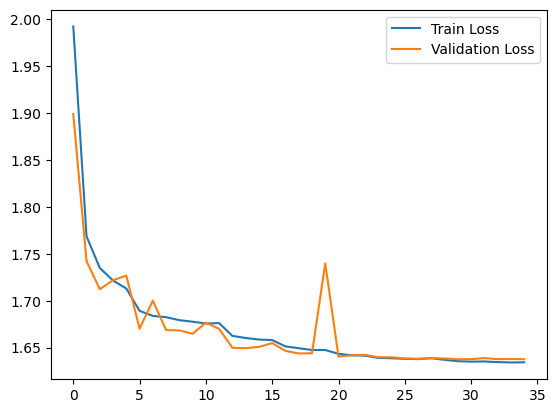

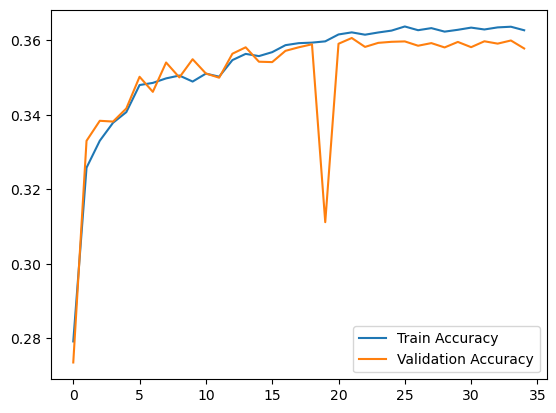

In [110]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

### Check for Imbalance

In [84]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 33079, 1: 33053, 2: 33149, 3: 32958, 4: 32375, 5: 29604, 6: 23407, 7: 16388, 8: 10614, 9: 6434, 10: 3240, 11: 1560, 12: 112, 13: 37, 14: 3, 15: 2, 16: 2, 17: 2, 18: 1, 19: 1}


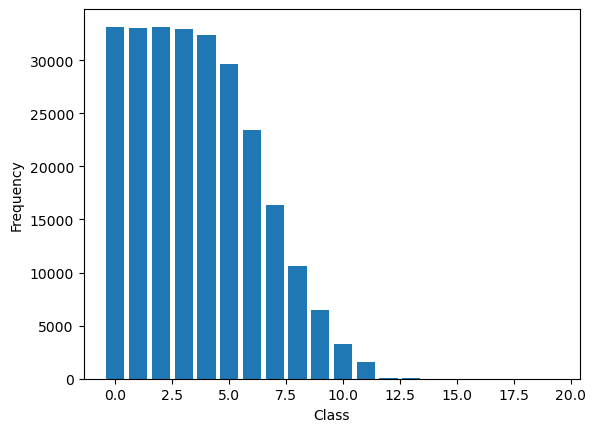

In [85]:
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = df[['speed', 'progress', 'stride_frequency', 'longitude', 'latitude', 'post_pos', 'official_fin']].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Define your variables
max_seq_length = 120  # Replace with your maximum sequence length
num_features = 5      # Replace with the actual number of features in your data
num_classes = 12      # Replace with the actual number of classes

# Build your model
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Masking(mask_value=0., input_shape=(max_seq_length, num_features)))
model_lstm.add(tf.keras.layers.LSTM(128))
model_lstm.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_lstm.summary()

In [ ]:
import tensorflow as tf
print(tf.__version__)


In [ ]:
# Load data into dataframe:

import pandas as pd

In [ ]:
# Training

history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Combining the Models

To create an ensemble, you can combine the predictions of these models in several ways:
	1.	Averaging Probabilities:
	•	Obtain probability distributions over finishing positions from each model.
	•	Average the probabilities across models to get the final prediction.
	2.	Weighted Averaging:
	•	Assign weights to each model based on validation performance.
	•	Compute a weighted average of the probabilities.
	3.	Stacking (Meta-Learner):
	•	Use the predictions from the individual models as input features to a meta-model (e.g., a logistic regression or another neural network).
	•	The meta-model learns how to best combine the individual predictions.
	4.	Voting (for Classification):
	•	If treating the problem as classification into discrete positions, use majority voting among the models.
	•	Not as suitable if you need probability distributions.

Implementation Steps

1. Data Preparation

	•	Sequences:
	•	Use the raw GPS data (gpspoint) to create sequences for each horse in each race.
	•	Ensure that sequences are properly sorted by time_stamp.
	•	Features:
	•	Include raw features such as speed, progress, stride_frequency.
	•	Avoid hand-engineering features like acceleration to adhere to your objective.
	•	Labels:
	•	Use official_fin from results_entries as the target variable.
	•	Since you want probabilities for each finishing position, consider encoding official_fin as categorical labels.
